In [1]:
import tensorflow as tf

from keras.layers import Conv2D, AveragePooling2D, BatchNormalization, Input, Dense, Flatten, ZeroPadding2D, MaxPooling2D,Dropout
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from keras.layers.advanced_activations import ReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Add
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Config variables
# Data images are not of the same size
INPUT_SIZE = [128, 128]
BATCH = 16

In [3]:
# No data augmentation
train_val_image_data_generator = ImageDataGenerator(rescale=1.0/255,
                                            rotation_range=20,
                                            zoom_range=0.2,
                                            width_shift_range=0.2,
                                            height_shift_range=0.2,
                                            shear_range=0.2,
                                            horizontal_flip=True,
                                            fill_mode="nearest",
                                            validation_split=0.2
                                            )

train_data = train_val_image_data_generator.flow_from_directory('./data/',
                                                     target_size = INPUT_SIZE,
                                                     batch_size=BATCH,
                                                     classes=['with_mask','without_mask'],
                                                     subset='training',
                                                     shuffle=True
                                                     )
validate_data = train_val_image_data_generator.flow_from_directory('./data/',
                                                     target_size = INPUT_SIZE,
                                                     batch_size=BATCH,
                                                     classes=['with_mask','without_mask'],
                                                     subset='validation',
                                                     shuffle=True
                                                     )

Found 6043 images belonging to 2 classes.
Found 1510 images belonging to 2 classes.


In [4]:
def identity_block(x, filters):
    
    x_skip = x
    f1 = filters

    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1),  padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Add()([x, x_skip])
    x = ReLU()(x)
    return x

def conv_block(x, s, filters):
    x_skip = x
    f1= filters

    x = Conv2D(f1, kernel_size=(3, 3), strides=(s, s), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)

    x_skip = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid')(x_skip)
    x_skip = BatchNormalization()(x_skip)

    x = Add()([x, x_skip])
    x = ReLU()(x)

    return x

input = Input(shape=INPUT_SIZE + [3])
x = ZeroPadding2D(padding=(3, 3))(input)

x = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((3, 3), strides=(2, 2),padding='same')(x)

x = identity_block(x, filters=(64))
x = identity_block(x, filters=(64))


# 3th stage

x = conv_block(x, s=2, filters=(128))
x = identity_block(x, filters=(128))


# 4th stage

x = conv_block(x, s=2, filters=(256))
x = identity_block(x, filters=(256))


# 5th stage

x = conv_block(x, s=2, filters=(512))
x = identity_block(x, filters=(512))

x = AveragePooling2D()(x)
x = Flatten()(x)
# x = Dropout(0.5)(x)
x = Dense(units=2, activation='softmax')(x)

resnet = Model(inputs=input, outputs=x, name = 'Resnet')
resnet.summary()


Model: "Resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 64)   256         conv2d[0][0]                     
_____________________________________________________________________________________________

In [5]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5, 
    patience=3, 
    verbose=1)


resnet.compile(optimizer='SGD',loss='binary_crossentropy',metrics=['accuracy'])

# es = EarlyStopping(monitor="accuracy", patience=20, verbose=1, mode="auto")

resnet_r = resnet.fit( train_data, validation_data=validate_data,epochs=20, steps_per_epoch=len(train_data),validation_steps=len(validate_data),callbacks=[reduce_lr])

Epoch 1/20


KeyboardInterrupt: 

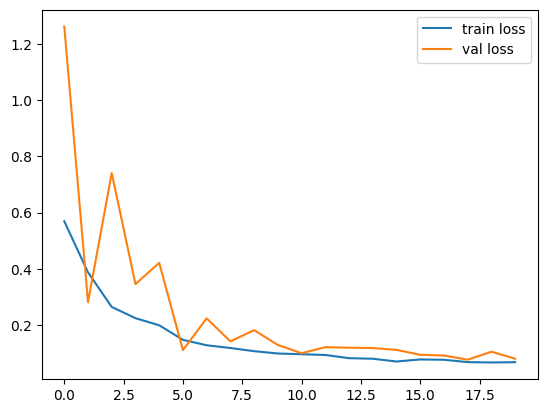

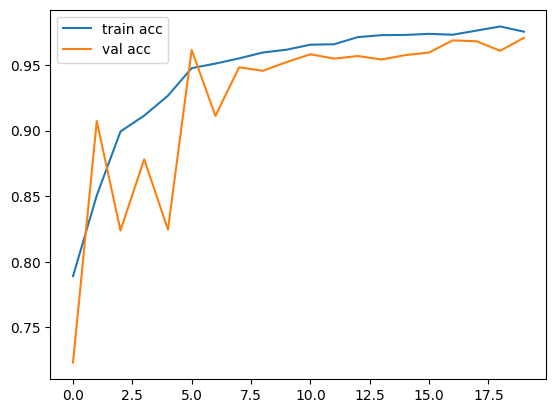

In [ ]:
plt.plot(resnet_r .history['loss'], label='train loss')
plt.plot(resnet_r .history['val_loss'], label='val loss')
plt.legend()
plt.show()


# plot the accuracy
plt.plot(resnet_r .history['accuracy'], label='train acc')
plt.plot(resnet_r .history['val_accuracy'], label='val acc')
plt.legend()
plt.show()